In [1]:
import numpy as np
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt


db_name = "GeSiNW_Qubit_VTI01_Jonas_2 (4).db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path

initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

plt.style.use('dark_background')

In [2]:
unpulsed = -load_by_run_spec(captured_run_id = 172 ).to_xarray_dataset()['I_SD'].to_numpy()
pulsed = -load_by_run_spec(captured_run_id = 174 ).to_xarray_dataset()['I_SD'].to_numpy()

# Original Detection

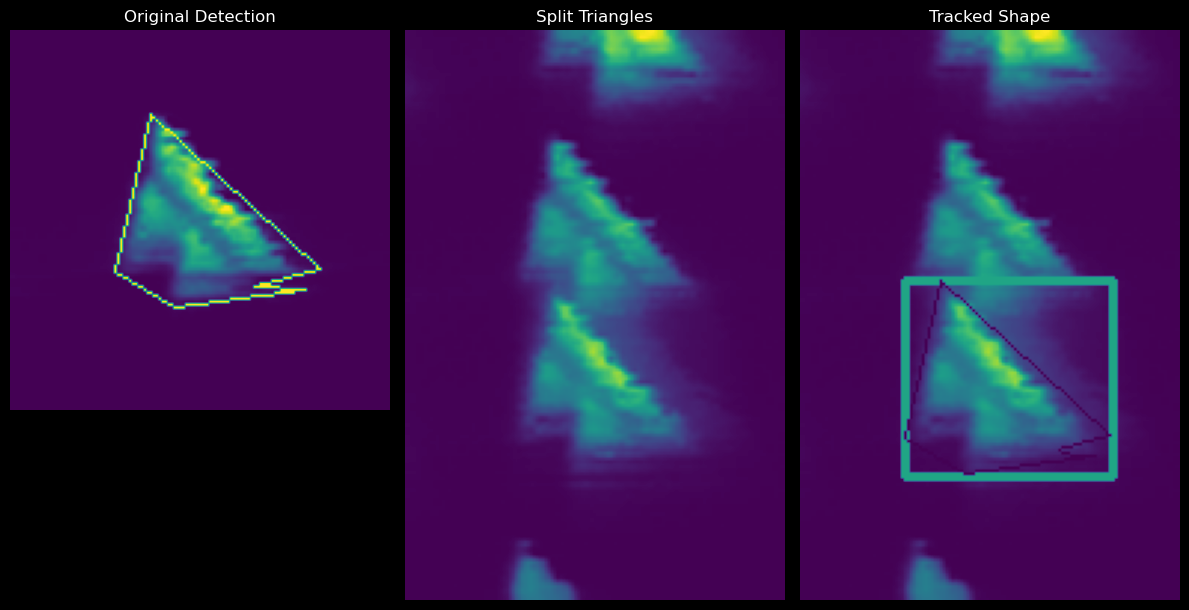

In [3]:
import btriangle_detection

gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(unpulsed,res = 2,min_area = 3, thr_method = 'triangle')
gray_orig2, _, _ = btriangle_detection.triangle_segmentation_alg(pulsed,res = 2,min_area = 3, thr_method = 'triangle')

im, _,_ , new_contour, shift = btriangle_detection.triangle_shape_matching(gray_orig, gray_orig2, masks)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(ims[0]) 
ax[0].axis('off') 
ax[0].set_title('Original Detection') 

ax[1].imshow(gray_orig2) 
ax[1].axis('off') 
ax[1].set_title('Split Triangles') 

ax[2].imshow(im) 
ax[2].axis('off') 
ax[2].set_title('Tracked Shape') 

fig.tight_layout()
plt.show() 

# User-corrected Detection

The argument __prior_dir__ allows specifications of 'up','down', 'right', 'left', which convey that the correct triangle to be detected is in the upper, lower etc half of the image. An optional tolerance value __tol__ which adds a padding of a certain number of pixels to the division line in question can be supplied - the default is 10 pixels.

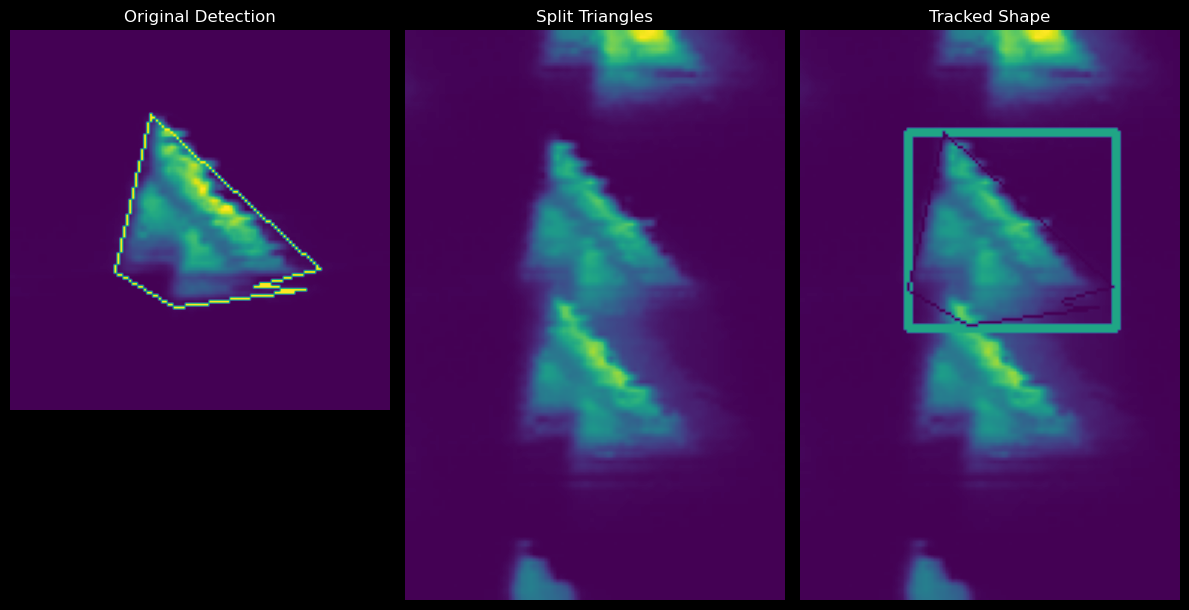

In [4]:
import btriangle_detection

gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(unpulsed,res = 2,min_area = 3, thr_method = 'triangle')
gray_orig2, _, _ = btriangle_detection.triangle_segmentation_alg(pulsed,res = 2,min_area = 3, thr_method = 'triangle')

im, _,_ , new_contour, shift = btriangle_detection.triangle_shape_matching(gray_orig, gray_orig2, masks, prior_dir = 'up')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(ims[0]) 
ax[0].axis('off') 
ax[0].set_title('Original Detection') 

ax[1].imshow(gray_orig2) 
ax[1].axis('off') 
ax[1].set_title('Split Triangles') 

ax[2].imshow(im) 
ax[2].axis('off') 
ax[2].set_title('Tracked Shape') 

fig.tight_layout()
plt.show()

/Users/madeleine/Downloads/btriangle_properties.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


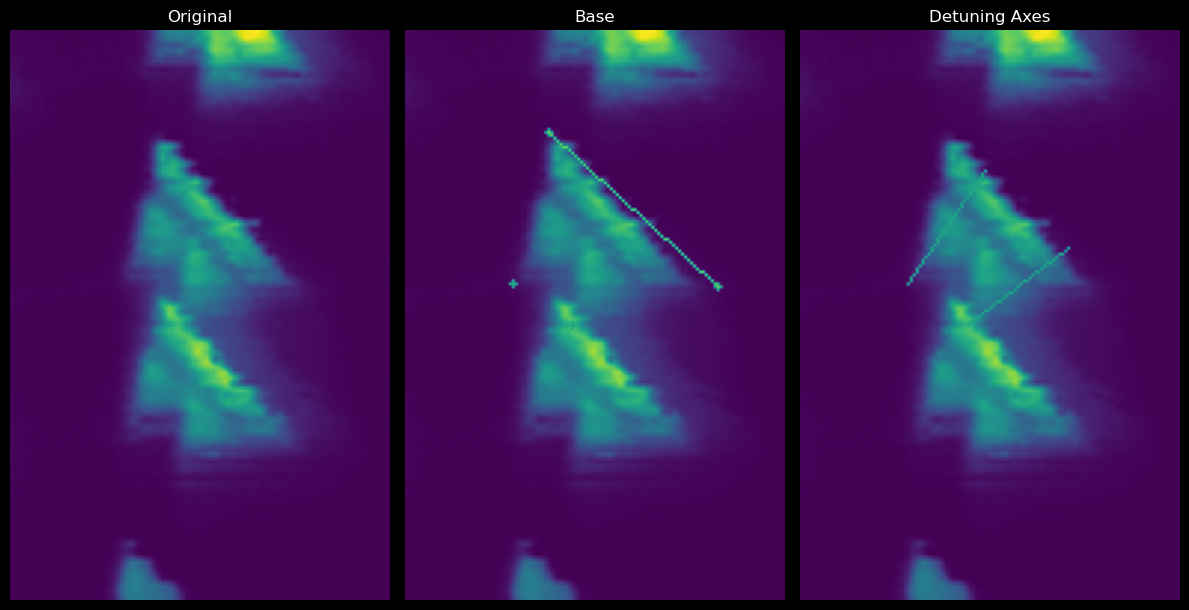

In [5]:
import cv2 as cv
import btriangle_properties

mask_new = np.zeros(gray_orig2.shape, np.uint8)
cv.drawContours(mask_new, [new_contour], -1, (255, 255, 255), -1)

base, corner_pts, c_im = btriangle_properties.detect_base_alt_slope(gray_orig2, mask_new, 'down')


axes_points,axes,line_img = btriangle_properties.detect_detuning_axis(gray_orig2, base, corner_pts)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig2) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(c_im) 
ax[1].axis('off') 
ax[1].set_title('Base') 

ax[2].imshow(line_img) 
ax[2].axis('off') 
ax[2].set_title('Detuning Axes') 
fig.tight_layout()
plt.show() 

# Refined Detuning Axis

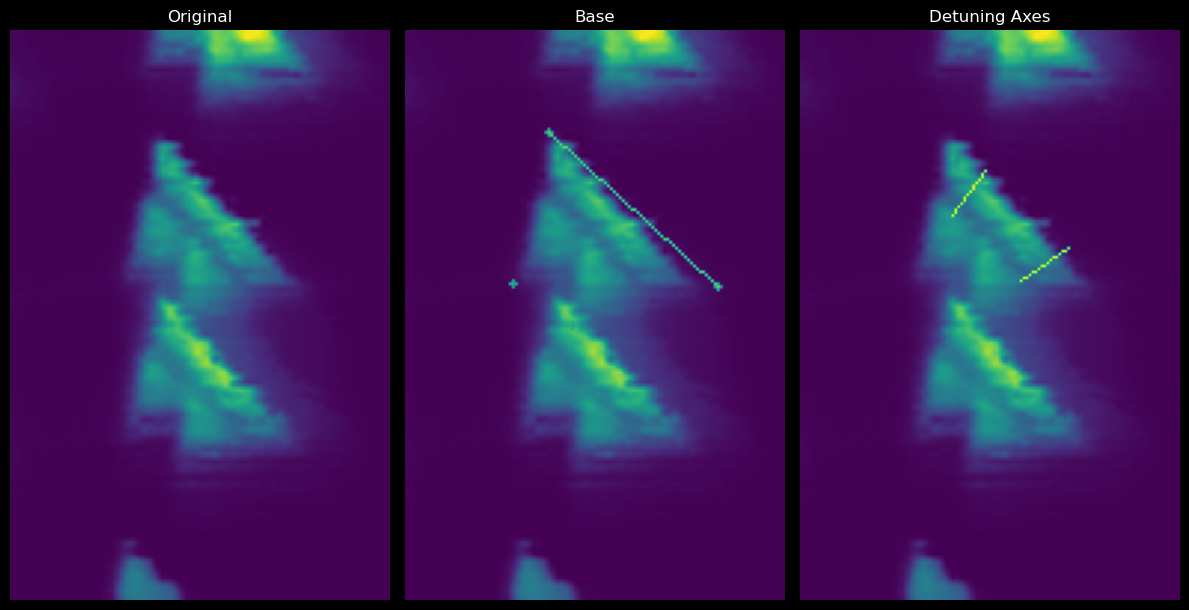

In [6]:
mask_new = np.zeros(gray_orig2.shape, np.uint8)
cv.drawContours(mask_new, [new_contour], -1, (255, 255, 255), -1)

base, corner_pts, c_im = btriangle_properties.detect_base_alt_slope(gray_orig2, mask_new, 'down')


line_img, axes_points = btriangle_properties.detect_refined_detuning_axis(gray_orig2, gray_orig, base, corner_pts, shift,padding_factor = 1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),sharex=True, sharey=True)

ax[0].imshow(gray_orig2) 
ax[0].axis('off') 
ax[0].set_title('Original') 

ax[1].imshow(c_im) 
ax[1].axis('off') 
ax[1].set_title('Base') 

ax[2].imshow(line_img) 
ax[2].axis('off') 
ax[2].set_title('Detuning Axes') 
fig.tight_layout()
plt.show() 

# Extract Triangle Segment for Readout Optimization

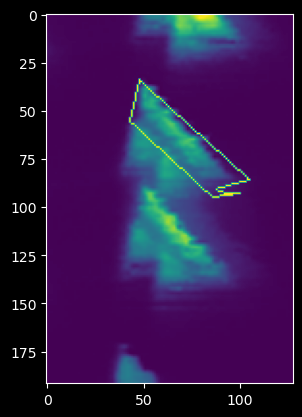

In [7]:
from alt_PSB_detection import get_triangle_seg


gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(unpulsed,res = 2,min_area = 3, thr_method = 'triangle')
gray_orig2, _, _ = btriangle_detection.triangle_segmentation_alg(pulsed,res = 2,min_area = 3, thr_method = 'triangle')

im, _,_ , new_contour, shift = btriangle_detection.triangle_shape_matching(gray_orig, gray_orig2, masks, prior_dir = 'up')

mask_new = np.zeros(gray_orig2.shape, np.uint8)
cv.drawContours(mask_new, [new_contour], -1, (255, 255, 255), -1)

base, corner_pts, c_im = btriangle_properties.detect_base_alt_slope(gray_orig, masks, 'down')

seg_coords,seg_im = get_triangle_seg(gray_orig2,gray_orig,base,mask_new,'down',shift)
plt.imshow(seg_im)